In [1]:
import numpy as np
from decimal import *
import numba
import matplotlib.pyplot as plt
import seaborn as sns
from dzigzag_class import dz_sampler
from dcoordinate_class import dc_sampler
from zanella_higher_order_class import hz_sampler
from mpl_toolkits import mplot3d
%matplotlib inline
sns.set()


@numba.njit()
def autocorr(x, lags):
    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return np.array(corr)


In [2]:
# primary parameter
prime = 53

# Build factor structure for lattice gauge theory
no_rows = 3
no_cols = 3

no_nodes = no_rows+no_cols + 2*(no_rows*no_cols)
no_factors = no_rows*no_cols

factor_matrix = np.zeros((no_factors, no_nodes)).astype("int64")

for factor in range(no_factors):
    # Initial starting point
    init_val = int(np.floor(factor/no_cols) * (2 * no_cols + 1) + factor % no_cols)
    
    # Build connections
    factor_matrix[factor, init_val] = 1
    factor_matrix[factor, init_val + no_cols] = 1
    factor_matrix[factor, init_val + no_cols + 1] = 1
    factor_matrix[factor, init_val + 2*no_cols + 1] = 1         
    
# Build connectivity placeholders
factor_nodes = []

for i in range(no_factors):
    factor_nodes.append(np.where(factor_matrix[i, :] > 0))
    
node_factors = []

for j in range(no_nodes):
    node_factors.append(np.where(factor_matrix[:, j] > 0))

def barker(x):
    return x/(1+x)

def apply_gen(x, gen_id, theta, p=prime):
    y = x.copy()
    y[gen_id] = x[gen_id] + theta[gen_id] % p
    return y

def lattice_gauge_energy(x):
    hamiltonian = 0
    for i in range(no_factors):
        hamiltonian += 1 - np.cos(2*np.pi/prime * (np.sum(x[factor_nodes[i]])))
        
    return hamiltonian

def local_hamiltonian(x, factors = []):
    if len(factors) == 0:
        hamiltonian = np.zeros(no_factors)
        
        for i in range(no_factors):
            hamiltonian[i] = 1 - np.cos(2*np.pi/prime * (np.sum(x[factor_nodes[i][0]])))

        return hamiltonian
    else:
        hamiltonian = np.zeros(len(factors))
        j = 0
        for i in factors:
            hamiltonian[j] = 1 - np.cos(2*np.pi/prime * (np.sum(x[factor_nodes[i][0]])))
            j += 1
            
        return hamiltonian

def calculate_rates(x, theta, jump_rates = 0, generator_index = 0):
    forward_rates = np.zeros(no_nodes)
    backward_rates = np.zeros(no_nodes)
    
    theta_inverse = -1 * theta
    
    baseline_rate = local_hamiltonian(x)
    
    for i in range(no_nodes):
        forward_state = apply_gen(x, i, theta)
        backward_state = apply_gen(x, i, theta_inverse)
        
        forward_hamiltonian = local_hamiltonian(forward_state, node_factors[i][0]).sum()
        backward_hamiltonian = local_hamiltonian(backward_state, node_factors[i][0]).sum()
        
        forward_rates[i] = barker(np.exp(forward_hamiltonian - baseline_rate[node_factors[i][0]].sum()))
        backward_rates[i] = barker(np.exp(backward_hamiltonian - baseline_rate[node_factors[i][0]].sum()))
        
    return forward_rates, backward_rates

def local_rates(x, theta, v):
    theta_inverse = -1 * theta
    
    baseline_rate = local_hamiltonian(x)
    
    forward_state = apply_gen(x, v, theta)
    backward_state = apply_gen(x, v, theta_inverse)
    
    forward_hamiltonian = local_hamiltonian(forward_state, node_factors[v][0]).sum()
    backward_hamiltonian = local_hamiltonian(backward_state, node_factors[v][0]).sum()
    
    return barker(np.exp(forward_hamiltonian - baseline_rate[node_factors[v][0]].sum())), barker(np.exp(backward_hamiltonian - baseline_rate[node_factors[v][0]].sum()))
        

In [112]:
T = 16000
thinning_ratio = 0.1
N = int(T/thinning_ratio)

# Model init
current_state = np.ones(no_nodes)
theta = np.ones(no_nodes)

samples, energy, iteration, runtime = dz_sampler(no_nodes,  # Dimension of the target
                                                no_nodes,  # Number of generators
                                                theta, # Velocities
                                                lattice_gauge_energy,  # Calculates the energy of the target density
                                                calculate_rates,  # Calculates the initial rates for the problem
                                                calculate_rates,  # Updates the rate after a flip has been carried out
                                                apply_gen,  # Applies the generator to the state
                                                current_state, T, thinning_ratio,
                                                calc_energy=True, print_rate=100)

Percent: [--------------------------------------->] 100%[16000.03665985]
Average jump length: [0.08039533]
Runtime: 276.81


Total ESS: 1110.35689674277
ESS/S: 4.011217308309291


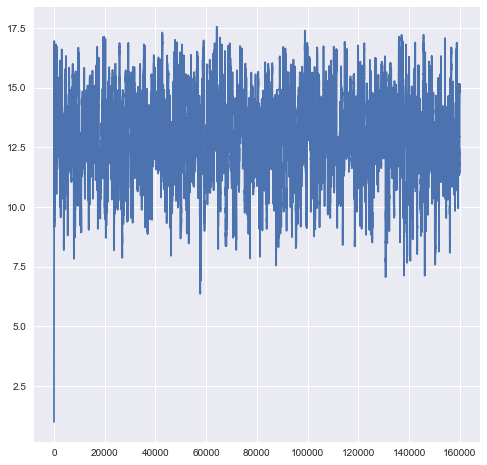

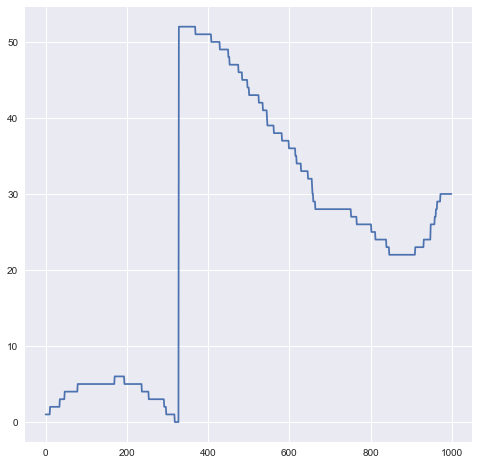

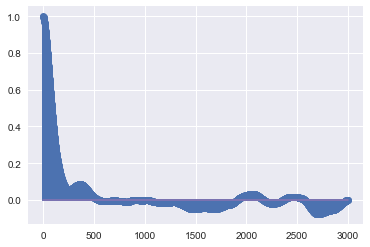

In [113]:
plt.figure(figsize=(8,8))
plt.plot(energy)
plt.figure(figsize=(8,8))
plt.plot(samples[:1000, 0] % prime)

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
ax.stem(autocorr(energy[int(0.2*N):], np.arange(0, 3000)))
ESS_E = N/(1+2*sum(autocorr(energy[int(0.2*N):], np.arange(0, 3000))))
print("Total ESS:", ESS_E)
print("ESS/S:", ESS_E/runtime)

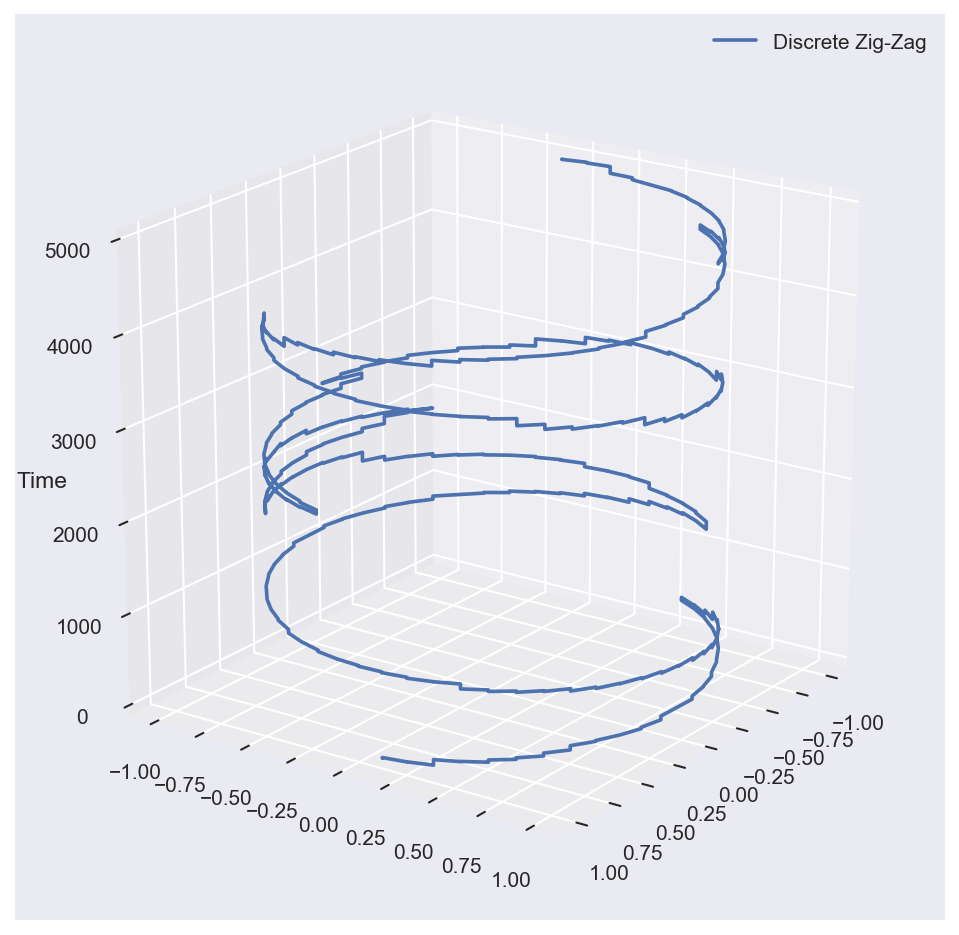

In [32]:
%matplotlib inline
no_points = 5000

fig = plt.figure(figsize=(8,8), dpi=150)
ax = plt.axes(projection='3d')

time = np.linspace(0, no_points, no_points)
x_data = np.cos(2*np.pi/prime * (samples[:no_points, 1] % prime))
y_data = np.sin(2*np.pi/prime * (samples[:no_points, 1] % prime))
ax.set_zlabel("Time")

ax.plot3D(x_data, y_data, time, label="Discrete Zig-Zag")
ax.legend()
ax.view_init(20, 35)

In [114]:
T = 2000000
thinning_ratio = 2
N = int(T/thinning_ratio)

# Model init
current_state = np.ones(no_nodes)
theta = np.ones(no_nodes)

samples_c, energy_c, iteration, runtim_c = dc_sampler(no_nodes,  # Dimension of the target
                                                    no_nodes,  # Number of generators
                                                    theta, 
                                                    lattice_gauge_energy,  # Calculates the energy of the target density
                                                    calculate_rates,  # Calculates the initial rates for the problem
                                                    local_rates,  # Updates the rate after a flip has been carried out
                                                    apply_gen,  # Applies the generator to the state
                                                    current_state, T, thinning_ratio,
                                                    calc_energy=True, print_rate=100)


Percent: [--------------------------------------->] 100%[2000006.6916261]
Average jump length: [1.92776189]
Runtime: 286.66


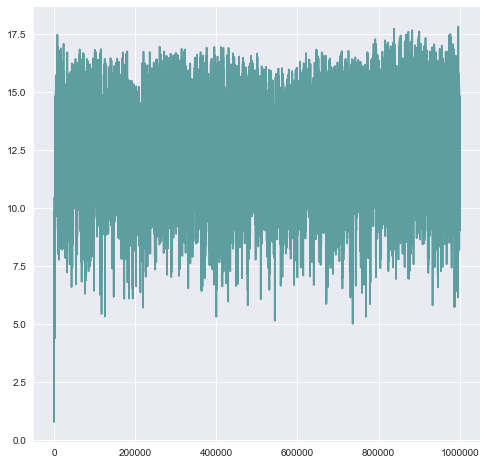

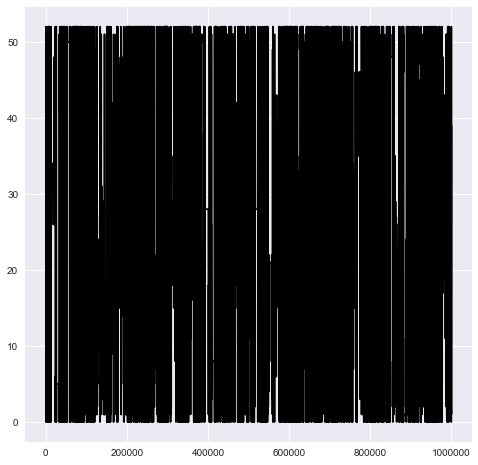

In [115]:
plt.figure(figsize=(8,8))
plt.plot(energy_c, color="cadetblue")
plt.figure(figsize=(8,8))
plt.plot(samples_c[:, 0] % prime, color="k")
plt.figure(figsize=(8,8))

Total ESS: 1509.5336585803866
ESS/S: 5.265956216692501


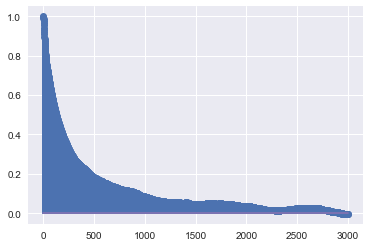

In [116]:
fig, ax = plt.subplots()
ax.stem(autocorr(energy_c[int(0.2*N):], np.arange(0, 3000)))
ESS_E = N/(1+2*sum(autocorr(energy_c[int(0.2*N):], np.arange(0, 3000))))
print("Total ESS:", ESS_E)
print("ESS/S:", ESS_E/runtim_c)

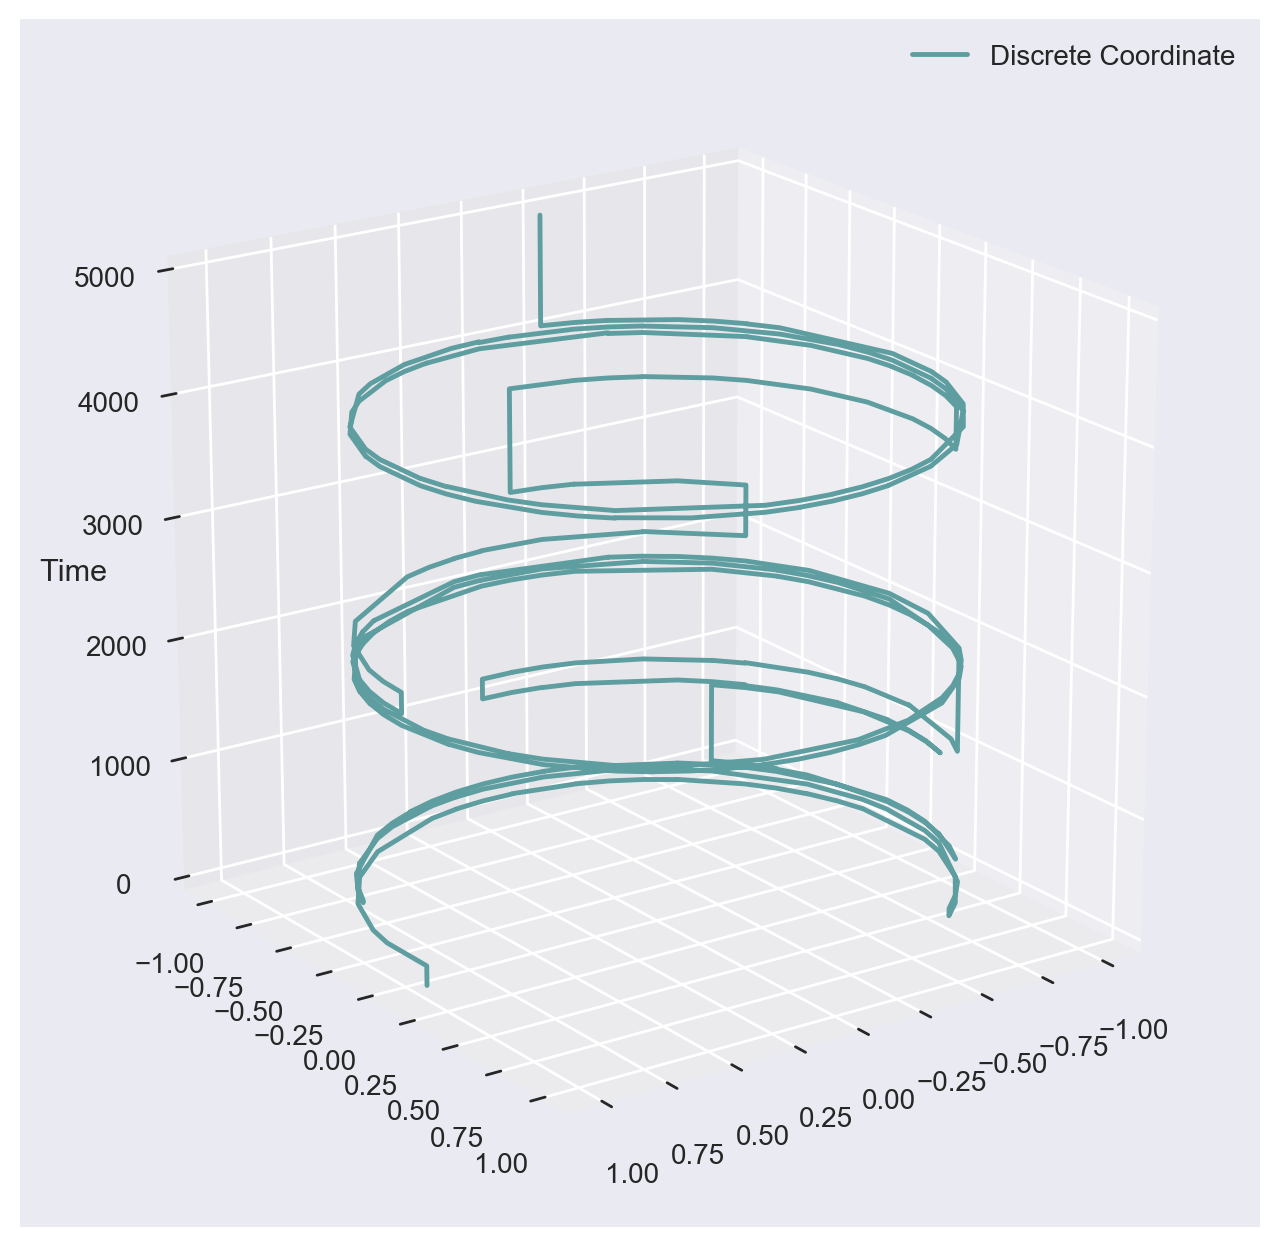

In [125]:
no_points = 5000

fig = plt.figure(figsize=(8,8), dpi=200)
ax = plt.axes(projection='3d')

time = np.linspace(0, no_points, no_points)
x_data = np.cos(2*np.pi/prime * (samples_c[:no_points, 8] % prime))
y_data = np.sin(2*np.pi/prime * (samples_c[:no_points, 8] % prime))
ax.set_zlabel("Time")

ax.plot3D(x_data, y_data, time, 'cadetblue', label="Discrete Coordinate")
ax.legend()
ax.view_init(20, 55)

In [21]:
def calculate_rates_saw(x, theta=0, jump_rates = 0, generator_index = 0):
    theta = np.ones(no_nodes)
    theta_inverse = np.ones(no_nodes) * -1
    
    forward_rates = np.zeros(2*no_nodes)
    
    baseline_rate = local_hamiltonian(x)
    
    i = 0
    for j in np.arange(0, 2*no_nodes, 2):
        forward_state = apply_gen(x, i, theta)
        backward_state = apply_gen(x, i, theta_inverse)
        
        forward_hamiltonian = local_hamiltonian(forward_state, node_factors[i][0]).sum()
        backward_hamiltonian = local_hamiltonian(backward_state, node_factors[i][0]).sum()
        
        forward_rates[j] = barker(np.exp(forward_hamiltonian - baseline_rate[node_factors[i][0]].sum()))
        forward_rates[j+1] = barker(np.exp(backward_hamiltonian - baseline_rate[node_factors[i][0]].sum()))
        i += 1
        
    return forward_rates

def apply_gen_saw(x, gen_id, p=prime):
    theta = np.empty((2*no_nodes,),int)
    theta[::2] = 1
    theta[1::2] = -1
    
    y = x.copy()
    y[int(np.floor(gen_id/2))] = x[int(np.floor(gen_id/2))] + theta[gen_id] % p
    return y


In [117]:
T = 8000
thinning_ratio = 0.05
N = int(T/thinning_ratio)

# Model init
current_state = np.ones(no_nodes)

samples_z, energy_z, iteration_z, runtime_z = hz_sampler(no_nodes, 2*no_nodes,
                                                              energy_function=lattice_gauge_energy,
                                                              calculate_rates=calculate_rates_saw,
                                                              update_rates=calculate_rates_saw,
                                                              apply_generator=apply_gen_saw,
                                                              current_state=current_state,
                                                              target_time=T,
                                                              thin_rate=thinning_ratio)

Percent: [--------------------------------------->] 100%[8000.07974361]
Average jump length: [0.04177369]
Runtime: 274.19


Total ESS: 141.25933973813696
ESS/S: 0.5151860462565337


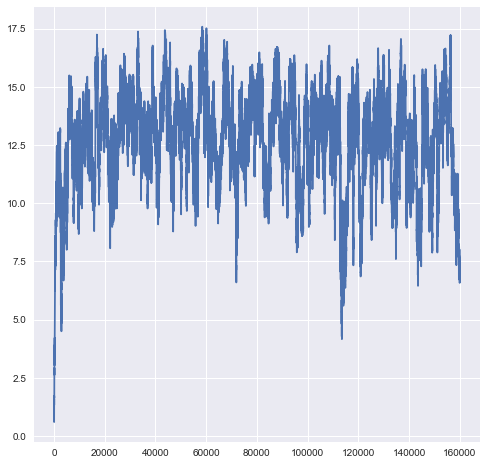

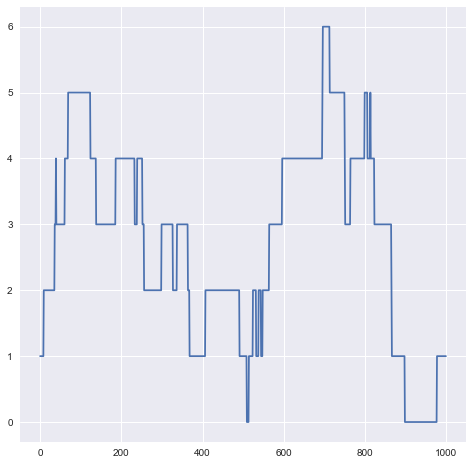

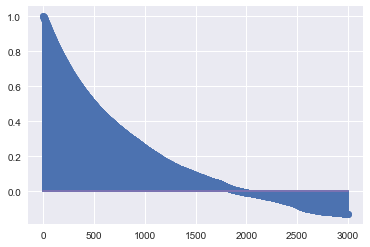

In [118]:
plt.figure(figsize=(8,8))
plt.plot(energy_z)
plt.figure(figsize=(8,8))
plt.plot(samples_z[:1000, 0] % prime)

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
ax.stem(autocorr(energy_z[int(0.2*N):], np.arange(0, 3000)))
ESS_E = N/(1+2*sum(autocorr(energy_z[int(0.2*N):], np.arange(0, 3000))))
print("Total ESS:", ESS_E)
print("ESS/S:", ESS_E/runtime_z)

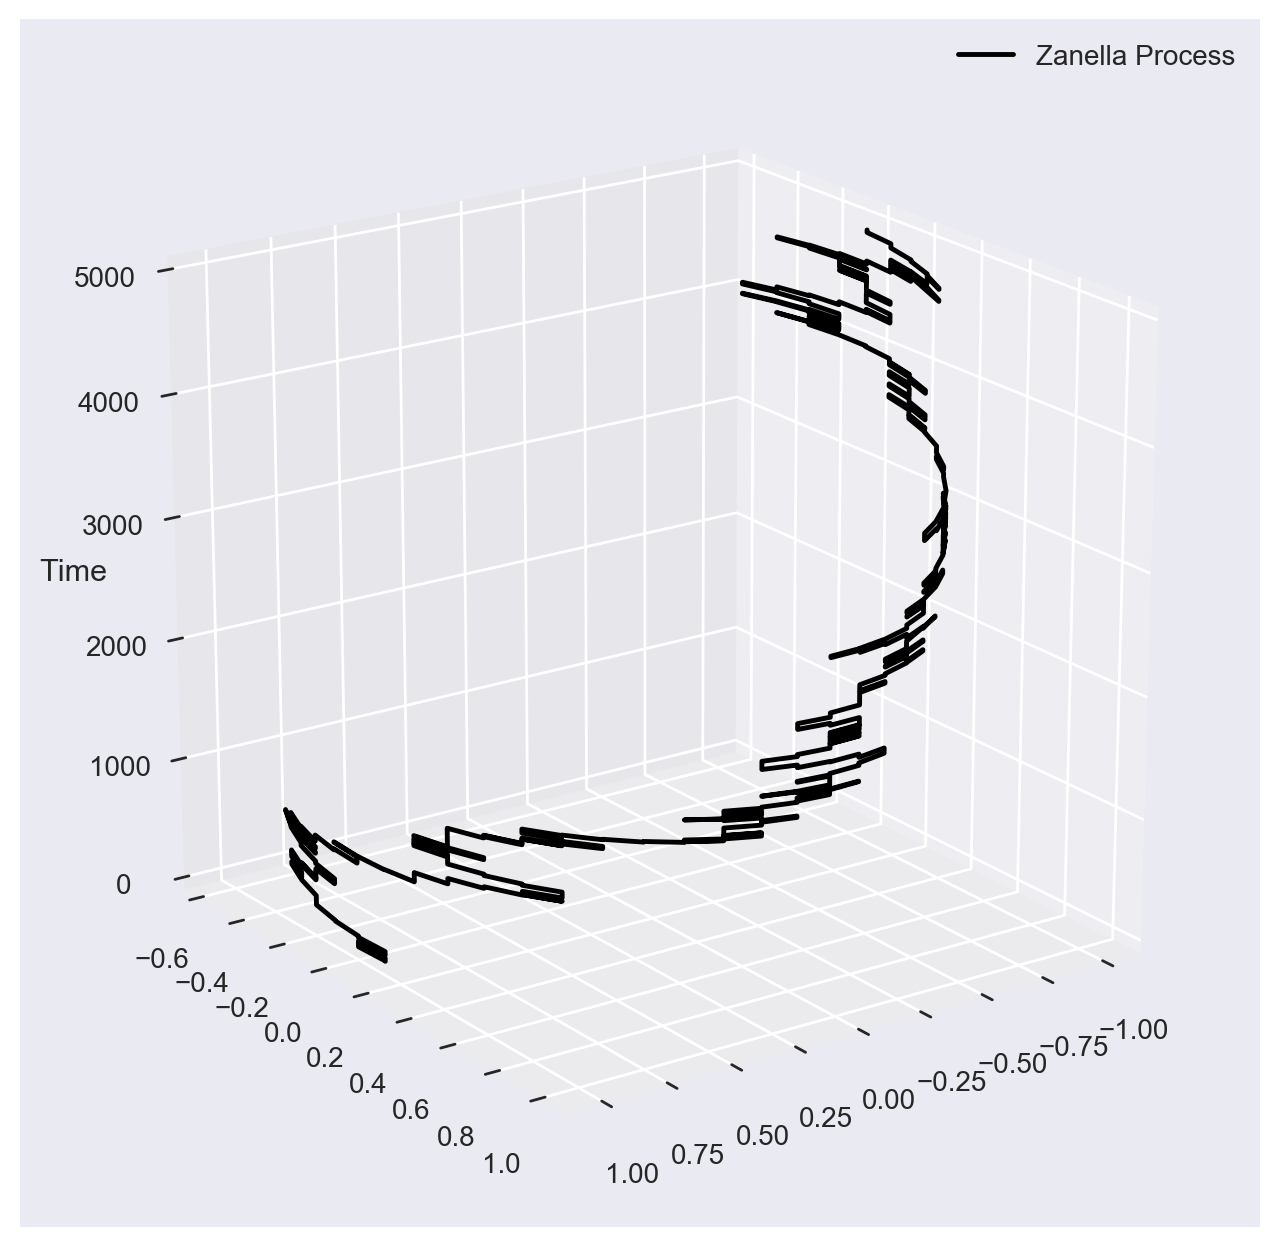

In [29]:
%matplotlib inline
no_points = 5000

fig = plt.figure(figsize=(8,8), dpi=200)
ax = plt.axes(projection='3d')

time = np.linspace(0, no_points, no_points)
x_data = np.cos(2*np.pi/prime * (samples_z[:no_points, 1] % prime))
y_data = np.sin(2*np.pi/prime * (samples_z[:no_points, 1] % prime))
ax.set_zlabel("Time")

ax.plot3D(x_data, y_data, time, 'k', label="Zanella Process")
ax.legend()
ax.view_init(20, 55)

(-0.2, 1.1)

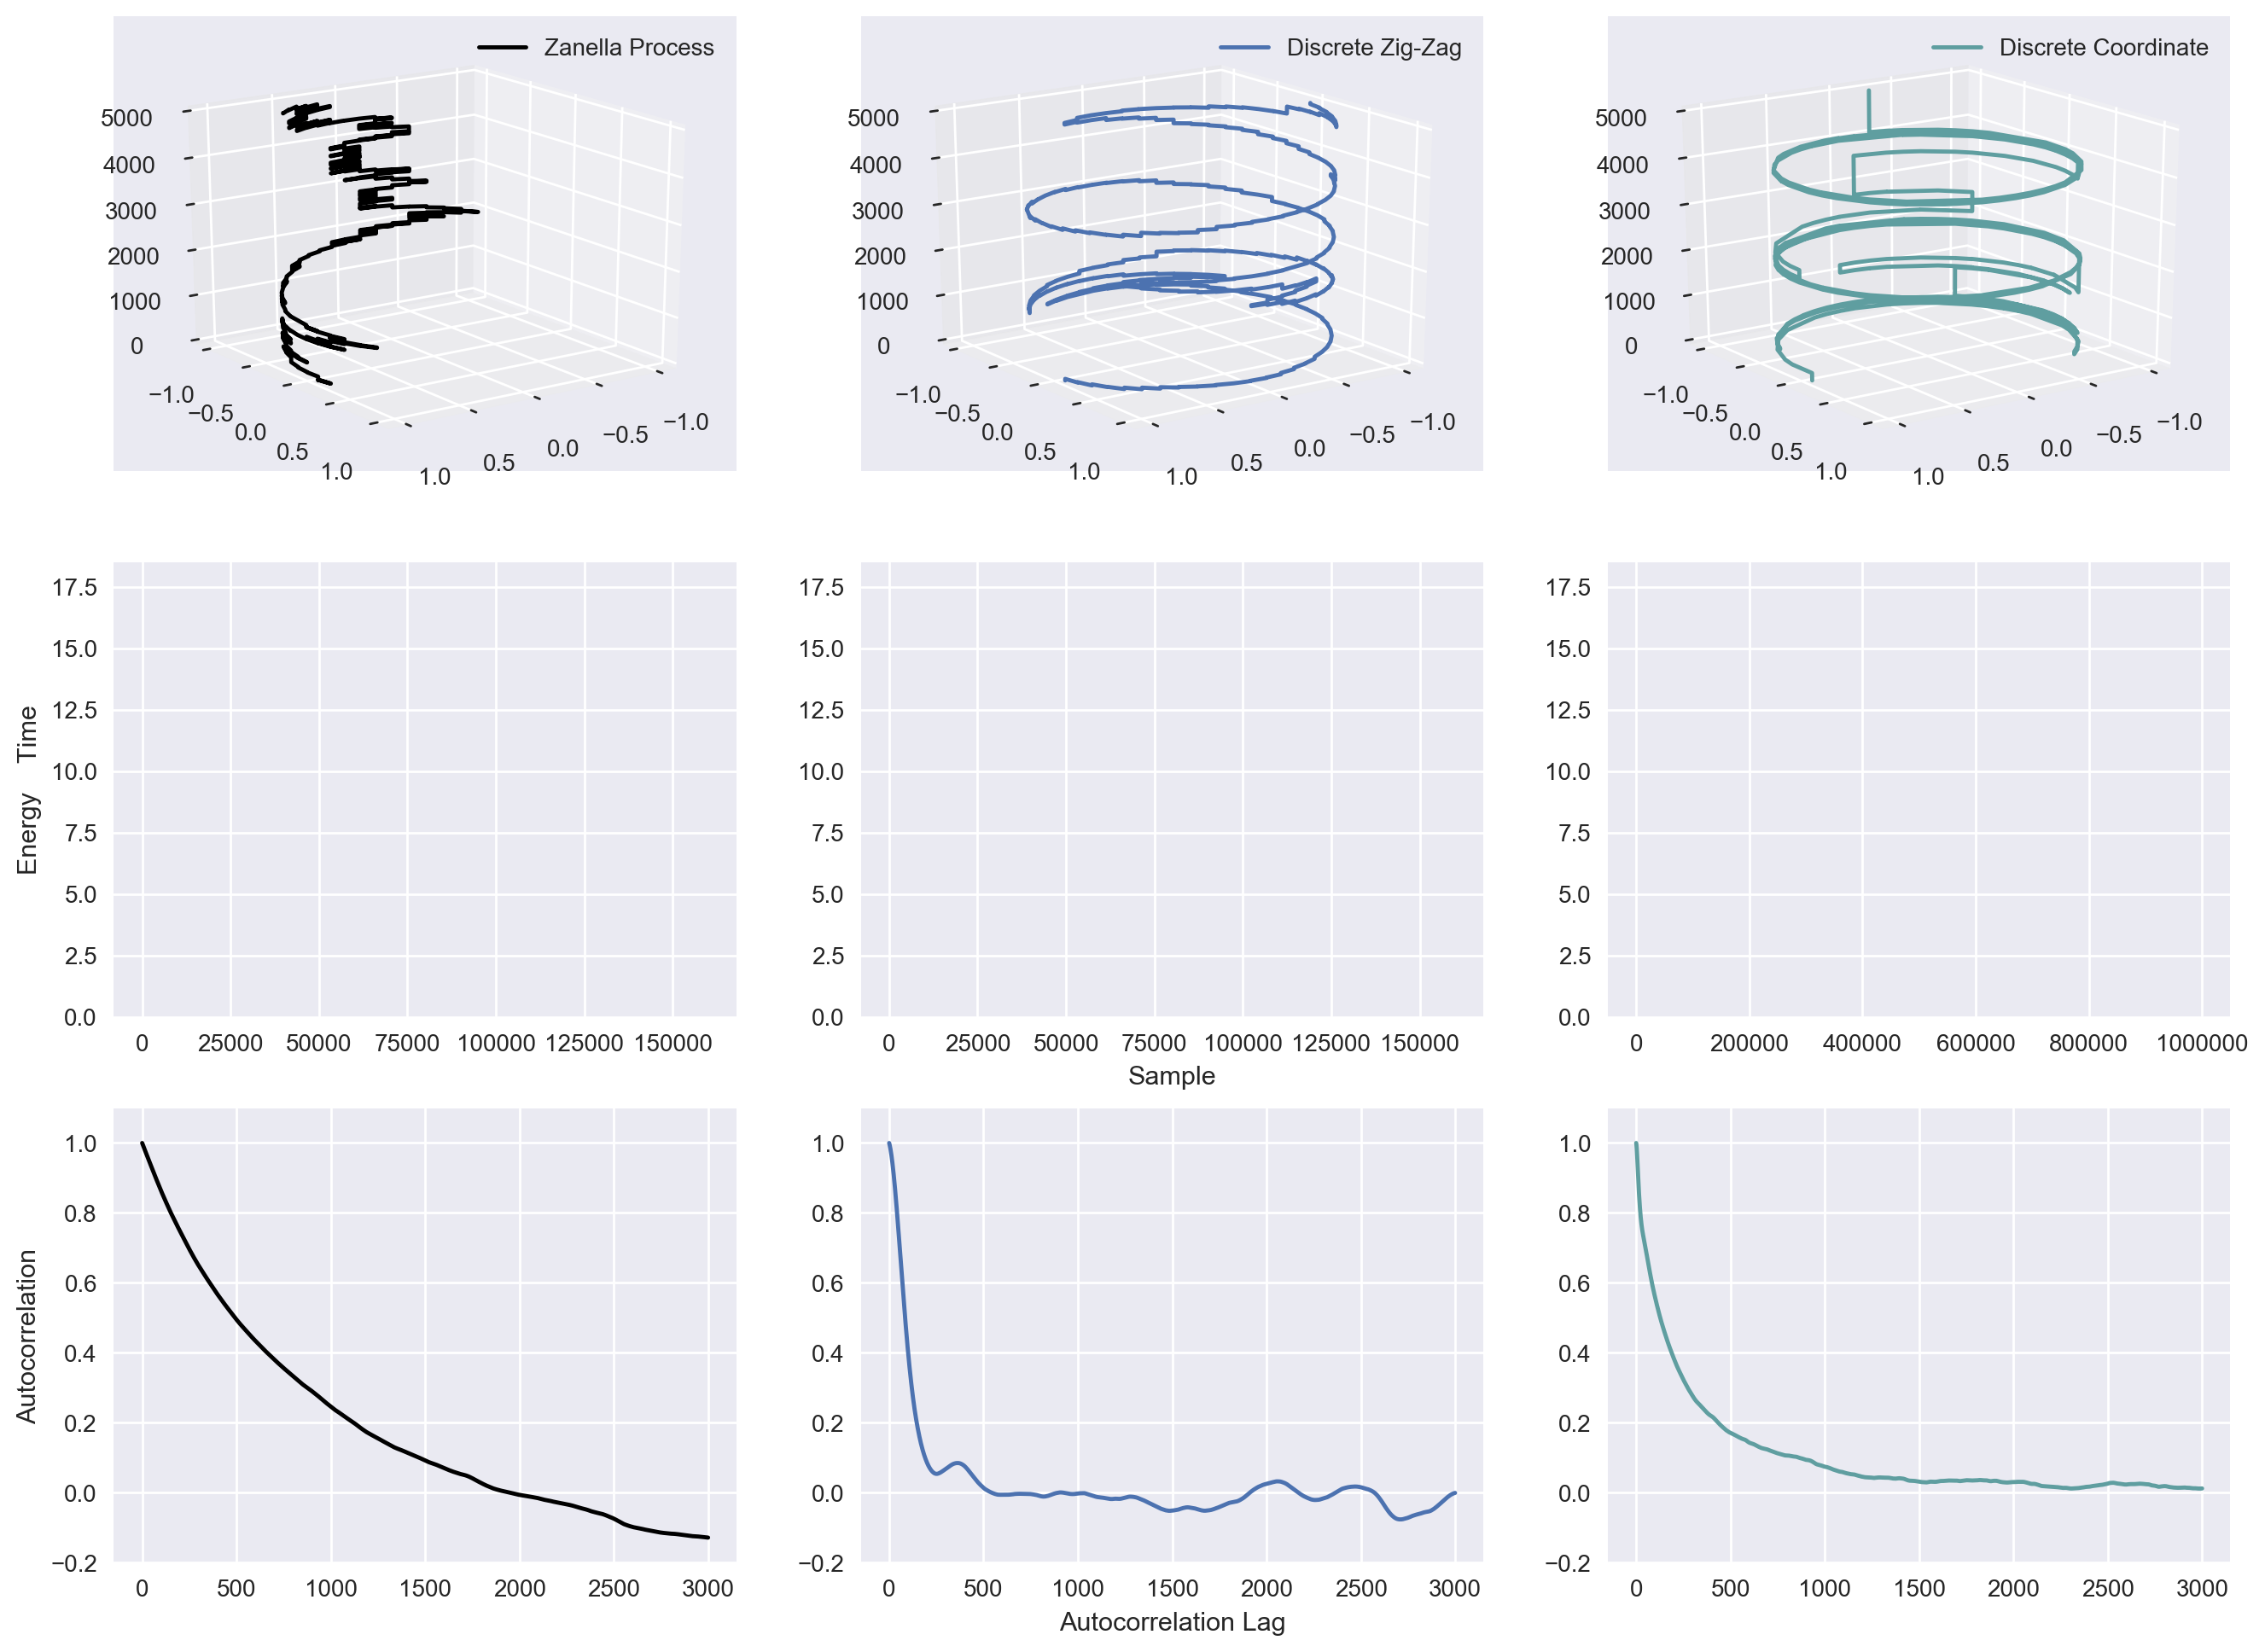

In [135]:
fig = plt.figure(figsize=(16, 12), dpi=200)

ax1 = fig.add_subplot(3, 3, 1, projection='3d')

time = np.linspace(0, no_points, no_points)
x_data = np.cos(2*np.pi/prime * (samples_z[:no_points, 1] % prime))
y_data = np.sin(2*np.pi/prime * (samples_z[:no_points, 1] % prime))

#ax1 = plt.axes(projection='3d')
ax1.plot3D(x_data, y_data, time, 'k', label="Zanella Process")
ax1.legend()
ax1.view_init(20, 55)
ax1.set_ylim(-1.1,1.1)
ax1.set_xlim(-1.1,1.1)

ax2 = fig.add_subplot(3, 3, 2, projection='3d')

x_data = np.cos(2*np.pi/prime * (samples[:no_points, 1] % prime))
y_data = np.sin(2*np.pi/prime * (samples[:no_points, 1] % prime))

#ax1 = plt.axes(projection='3d')
ax2.plot3D(x_data, y_data, time, label="Discrete Zig-Zag")
ax2.legend()
ax2.view_init(20, 55)

ax3 = fig.add_subplot(3, 3, 3, projection='3d')

x_data = np.cos(2*np.pi/prime * (samples_c[:no_points, 8] % prime))
y_data = np.sin(2*np.pi/prime * (samples_c[:no_points, 8] % prime))

#ax1 = plt.axes(projection='3d')
ax3.plot3D(x_data, y_data, time, 'cadetblue', label="Discrete Coordinate")
ax3.legend()
ax3.view_init(20, 55)

ax4 = fig.add_subplot(3, 3, 4)

ax4.plot(-energy_z, color="k")
ax4.set_ylim(0, 18.5)
ax4.set_ylabel("Energy    Time")

ax5 = fig.add_subplot(3, 3, 5)
ax5.set_ylim(0, 18.5)
ax5.set_xlabel("Sample")

ax5.plot(-energy)

ax6 = fig.add_subplot(3, 3, 6)

ax6.plot(-energy_c, color="cadetblue")
ax6.set_ylim(0, 18.5)

ax7 = fig.add_subplot(3,3,7)

ax7.plot(autocorr(energy_z[int(0.2*N):], np.arange(0, 3000)), color="k")
ax7.set_ylim(-0.2, 1.1)
ax7.set_ylabel("Autocorrelation")

ax8 = fig.add_subplot(3,3,8)

ax8.plot(autocorr(energy[int(0.2*N):], np.arange(0, 3000)))
ax8.set_xlabel("Autocorrelation Lag")
ax8.set_ylim(-0.2, 1.1)

ax9 = fig.add_subplot(3,3,9)
ax9.plot(autocorr(energy_c[int(0.2*N):], np.arange(0, 3000)), color="cadetblue")
ax9.set_ylim(-0.2, 1.1)
